# Module objectives
- Creating a graph from structured data input
- Basic Cypher Queries & Pattern Matching
- Basic Vector Search
- Feature engineering with Graph Algorithms


In [46]:
%pip install graphdatascience neo4j dotenv matplotlib langchain langchain-openai langgraph pydantic

  Using cached msgpack-1.1.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.4 kB)
Using cached msgpack-1.1.0-cp311-cp311-macosx_11_0_arm64.whl (81 kB)
Note: you may need to restart the kernel to use updated packages.


## Setup

Import our usual suspects

In [7]:
import os
import pandas as pd
from dotenv import load_dotenv
from graphdatascience import GraphDataScience
from neo4j import Query, GraphDatabase, RoutingControl, Result

Load env variables

In [8]:
load_dotenv('ws.env', override=True)
# Neo4j
HOST = os.getenv('NEO4J_URI')
USERNAME = os.getenv('NEO4J_USERNAME')
PASSWORD = os.getenv('NEO4J_PASSWORD')
DATABASE = os.getenv('NEO4J_DATABASE', 'neo4j')

# AI
LLM = os.getenv('LLM')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY']=OPENAI_API_KEY

Connect to neo4j db

In [9]:
driver = GraphDatabase.driver(
    HOST,
    auth=(USERNAME, PASSWORD)
)
driver.verify_connectivity(database=DATABASE)

/Users/zachblumenfeld/opt/anaconda3/envs/genai-workshop-2025-3/lib/python3.11/site-packages/neo4j/_sync/driver.py:1075: ExperimentalWarning: All configuration key-word arguments to verify_connectivity() are experimental. They might be changed or removed in any future version without prior notice.
  experimental_warn(


## Graph Creation

In [10]:
## Utility - not needed for this small dataset, but as best practice example
def split_dataframe(df, chunk_size = 50_000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [11]:
# Load synthetic Skills dataset
url = "https://raw.githubusercontent.com/Kristof-Neys/Neo4j_demos/main/expanded_skills.csv"
skills_csv = pd.read_csv(url)

# Display the first few rows of the DataFrame
skills_csv.head(30)

,email,name,skills
0,thomas.nelson@test.org,Thomas Nelson,"Security, Pandas, Go"
1,lucy.clark@test.org,Lucy Clark,"WordPress, Scrum, Go, SQL, Linux"
2,richard.jackson@test.org,Richard Jackson,"System Design, PyTorch, Express.js, DevOps"
3,amelia.hall@test.org,Amelia Hall,"Agile, CSS3, R, Azure"
4,david.hill@test.org,David Hill,"Java, Scrum, Angular"
5,christopher.johnson@test.org,Christopher Johnson,"Tableau, Flask, API Design"
6,amelia.martin@test.org,Amelia Martin,"CI/CD, Kotlin, HTML5, TensorFlow"
7,daniel.hill@test.org,Daniel Hill,"System Design, Git, Cypher, Pandas, Spring Boot"
8,alice.white@test.org,Alice White,"Spark, Agile, JavaScript"
9,lucy.taylor@test.org,Lucy Taylor,"Flask, Tableau, CI/CD, Rust, System Design"


In [12]:
# Convert skills column from comma separated string to List
skills_csv['skills'] = skills_csv['skills'].str.split(', ')
skills_csv.head()

,email,name,skills
0,thomas.nelson@test.org,Thomas Nelson,"[Security, Pandas, Go]"
1,lucy.clark@test.org,Lucy Clark,"[WordPress, Scrum, Go, SQL, Linux]"
2,richard.jackson@test.org,Richard Jackson,"[System Design, PyTorch, Express.js, DevOps]"
3,amelia.hall@test.org,Amelia Hall,"[Agile, CSS3, R, Azure]"
4,david.hill@test.org,David Hill,"[Java, Scrum, Angular]"


### Schema

In [13]:
schema_statements = [
    'create constraint if not exists for (n:Person) require (n.email) is node key',
    'create constraint if not exists for (n:Skill) require (n.name) is node key',
]
for statement in schema_statements:
    driver.execute_query(
        statement,
        database_=DATABASE,
        routing_=RoutingControl.WRITE
    )

# Fetch all constraints
schema_result_df  = driver.execute_query(
    'show constraints',
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)
schema_result_df.head(100)


,id,name,type,entityType,labelsOrTypes,properties,ownedIndex,propertyType
0,5,constraint_63bf11a1,NODE_KEY,NODE,[Skill],[name],constraint_63bf11a1,None
1,3,constraint_d3bfd313,NODE_KEY,NODE,[Person],[email],constraint_d3bfd313,None


In [14]:
# Create a graph for (:Person)-[:KNOWS]->(:Skill)
for chunk in split_dataframe(skills_csv):
    records, summary, keys = driver.execute_query(
        '''
            unwind $rows as row
            merge (p:Person{email:row.email})
            set p.name = row.name
            with p, row
            foreach(skill in row.skills | merge (s:Skill{name:skill}) merge (p)-[:KNOWS]->(s) )
            return count(*) as rows_processed
        ''',
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        rows = chunk.to_dict('records')
    )

## Basic navigation of graph with cypher

In [15]:
# What persons are in the database?
driver.execute_query(
    '''
    match (p:Person)
    return p.name as person_name
    ''',
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
).head()

,person_name
0,Thomas Nelson
1,Lucy Clark
2,Richard Jackson
3,Amelia Hall
4,David Hill


In [16]:
# What skills does each person know?
driver.execute_query(
    '''
    match (p:Person)-[:KNOWS]->(s:Skill)
    return p.email as email, p.name as person_name,collect(s.name) as skills
    ''',
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
).head()

,email,person_name,skills
0,christopher.johnson@test.org,Christopher Johnson,"[API Design, Flask, Tableau]"
1,victoria.thomas@test.org,Victoria Thomas,"[API Design, Cloud Architecture, Swift]"
2,hannah.campbell@test.org,Hannah Campbell,"[API Design, DevOps, JavaScript, Power BI, Vue..."
3,brian.jackson@test.org,Brian Jackson,"[API Design, Cloud Architecture, Jenkins, Proj..."
4,john.walker@test.org,John Walker,"[API Design, Django, Python]"


In [17]:
# What are the most frequent skills?
driver.execute_query(
    '''
    match (p:Person)-[:KNOWS]->(s:Skill)
    return s.name, count(distinct p) as knownByCount order by knownByCount desc limit 10
    ''',
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
).head()

,s.name,knownByCount
0,System Design,14
1,Agile,13
2,Security,13
3,Angular,13
4,Blockchain,11


In [18]:
# Which people share the most skills?
driver.execute_query(
    '''
    match (p1:Person)-[:KNOWS]->(s:Skill)<-[:KNOWS]-(p2)
    where p1 < p2
    return p1.name as name1, p2.name as name2, collect(s.name) as skills, count(s) AS skillsCount
    order by skillsCount desc limit 10
    ''',
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
).head()

,name1,name2,skills,skillsCount
0,Isabella Martin,Matthew Mitchell,"[Blockchain, HTML5, R]",3
1,Joseph Lopez,Christopher Jackson,"[Django, Linux, System Design]",3
2,Joseph Martin,Kevin Young,"[Agile, Linux, ReactJS]",3
3,Matthew Scott,David Rodriguez,"[Azure, Cypher, Scrum]",3
4,Daniel Hill,Daniel Hall,"[Cypher, Spring Boot, System Design]",3


In [19]:
# Which people have the most skills in common?
driver.execute_query(
'''
match (p1:Person)-[:KNOWS]->(s:Skill)<-[:KNOWS]-(p2)
where p1 < p2
return p1.name as name1, p2.name as name2, collect(s.name) as skills, count(s) AS skillsCount
order by skillsCount desc limit 10
''',
database_ = DATABASE,
routing_ = RoutingControl.READ,
result_transformer_ = lambda r: r.to_df()
)

,name1,name2,skills,skillsCount
0,Isabella Martin,Matthew Mitchell,"[Blockchain, HTML5, R]",3
1,Joseph Lopez,Christopher Jackson,"[Django, Linux, System Design]",3
2,Joseph Martin,Kevin Young,"[Agile, Linux, ReactJS]",3
3,Matthew Scott,David Rodriguez,"[Azure, Cypher, Scrum]",3
4,Daniel Hill,Daniel Hall,"[Cypher, Spring Boot, System Design]",3
5,Ryan Rodriguez,Hannah Campbell,"[DevOps, JavaScript, Power BI]",3
6,Charles Jones,John Taylor,"[AWS, CSS3, Pandas]",3
7,Brian Thompson,John Baker,"[Agile, Data Analysis, PHP]",3
8,Natalie Thompson,Ryan Jones,"[Angular, Jenkins, Spark]",3
9,Thomas Brown,Amelia Davis,"[Docker, Java, Security]",3


In [20]:
# Which people have the most skills overlap?
driver.execute_query(
    '''
    match (p1:Person)-[:KNOWS]->(s:Skill)<-[:KNOWS]-(p2)
    where p1 < p2
    with p1.name as name1, p2.name as name2, 
        count{(p1)-[:KNOWS]->()} as p1Skills,
        count{(p2)-[:KNOWS]->()} as p2Skills,
        collect(s.name) as sharedSkillsList,
        toFloat(count(s)) AS sharedSkills
    RETURN name1, 
        name2, 
        CASE WHEN p1Skills > p2Skills 
            THEN sharedSkills/p1Skills
            ELSE sharedSkills/p2Skills
            END AS skillsOverlap,
        sharedSkillsList
    order by skillsOverlap desc limit 5
    ''',
    database_ = DATABASE,
    routing_ = RoutingControl.READ,
    result_transformer_ = lambda r: r.to_df()
)

,name1,name2,skillsOverlap,sharedSkillsList
0,Matthew Scott,David Rodriguez,0.750000,"[Azure, Cypher, Scrum]"
1,Alice White,Charles Carter,0.666667,"[JavaScript, Spark]"
2,David Hill,Sophie Perez,0.666667,"[Angular, Scrum]"
3,Charles Jones,John Taylor,0.600000,"[AWS, CSS3, Pandas]"
4,Joseph Martin,Kevin Young,0.600000,"[Agile, Linux, ReactJS]"


## Basic Vector Search

In [21]:
# Import langchain open ai
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')


In [22]:
skills_df = driver.execute_query(
    'match (s:Skill) return s.name as skill',
    result_transformer_ = lambda r: r.to_df()
)
skills_df.head(35)

,skill
0,API Design
1,AWS
2,Agile
3,Angular
4,Azure
5,Big Data
6,Blockchain
7,C++
8,CI/CD
9,CSS3


### STOP STOP STOP - DO NOT PROCEED (YET)

In [23]:
# only to be run by instructor (or if you have your own api key)
# to-do: Don't do row-by-row, use bulk.

#skills_df['embedding'] = skills_df['skill'].apply( lambda skill: embeddings.embed_documents([skill])[0])
#skills_df.head()

,skill,embedding
0,API Design,"[0.002335607074201107, -0.021444285288453102, ..."
1,AWS,"[-0.004132895264774561, -0.017077714204788208,..."
2,Agile,"[-0.03577807545661926, -0.01052175834774971, -..."
3,Angular,"[-0.006358983926475048, 0.015042469836771488, ..."
4,Azure,"[0.00941519346088171, -0.026340041309595108, 0..."


In [24]:
# driver.execute_query(
#     '''
#      unwind $rows as row
#      match (s:Skill{name: row.skill})
#      set s.embedding = row.embedding
#     ''',
#     database_=DATABASE,
#     routing_=RoutingControl.WRITE,
#     rows =  skills_df.to_dict(orient='records')
# )

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x1205fe350>, keys=[])

In [25]:
# Todo: Kristof, can you update this so it also has embeddings from text-embedding-ada-002
skills_df = pd.read_csv('https://raw.githubusercontent.com/Kristof-Neys/Neo4j_demos/refs/heads/main/skills_embeddings.csv')
skills_df['Embedding'] = skills_df['Embedding'].apply( lambda x: [ float(i) for i in x.strip("[]").split(", ")] )
skills_df.head()

,Name,Embedding
0,API Design,"[0.002335607074201107, -0.021444285288453102, ..."
1,AWS,"[-0.004132895264774561, -0.017077714204788208,..."
2,Agile,"[-0.03577807545661926, -0.01052175834774971, -..."
3,Angular,"[-0.006358983926475048, 0.015042469836771488, ..."
4,Azure,"[0.00941519346088171, -0.026340041309595108, 0..."


In [26]:
# Add embeddings to Skill nodes in database
driver.execute_query(
    '''
     unwind $rows as row
     match (s:Skill{name: row.skill})
     set s.embedding = row.embedding
    ''',
    database_=DATABASE,
    routing_=RoutingControl.WRITE,
    rows =  skills_df.to_dict(orient='records')
)

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x121134250>, keys=[])

### Let's use the semantic meaning to find similarities


In [27]:
# create vector index on text embeddings
driver.execute_query('''
create vector index ada_v if not exists for (n:Skill) on (n.embedding)
options {indexConfig: {
 `vector.dimensions`: toInteger($dimension),
 `vector.similarity_function`: 'cosine'
}}
''', dimension=1536)

# wait for index to come online
driver.execute_query('CALL db.awaitIndex("ada_v", 300)')

EagerResult(records=[], summary=<neo4j._work.summary.ResultSummary object at 0x12166c490>, keys=[])

In [28]:
# simple vector search
skill_search = "frontend developer"
driver.execute_query(
    '''
    call db.index.vector.queryNodes('ada_v', 10, $query_vector) yield node, score
    return node.name as skill, score
    ''',
    database_ = DATABASE,
    routing_ = RoutingControl.READ,
    result_transformer_ = lambda r: r.to_df(),
    query_vector = embeddings.embed_query(skill_search)
)

,skill,score
0,HTML5,0.923508
1,ReactJS,0.919846
2,Express.js,0.918228
3,DevOps,0.917343
4,JavaScript,0.916321
5,Node.js,0.914276
6,Java,0.908401
7,Angular,0.907059
8,CSS3,0.906677
9,Django,0.905594


In [29]:
# find semantically similar skills (via vector search)
driver.execute_query(
    '''
    match(skill:Skill) with skill order by skill.name limit 5
    call db.index.vector.queryNodes('ada_v', 4, skill.embedding) yield node, score
    WHERE node.name <> skill.name
    return skill.name as skill, score, node.name as to_skill
    ''',
    database_ = DATABASE,
    routing_ = RoutingControl.READ,
    result_transformer_ = lambda r: r.to_df()
).head()

,skill,score,to_skill
0,API Design,0.915894,System Design
1,API Design,0.901398,Project Management
2,API Design,0.901276,Express.js
3,AWS,0.944397,Azure
4,AWS,0.905319,WordPress


In [30]:
# persist semantic relationships for performance
driver.execute_query(
    '''
    match(skill:Skill)
    call db.index.vector.queryNodes('ada_v', 20, skill.embedding) yield node, score
    WHERE node < skill AND score > 0.9 //choose a reasonable number based on above
    MERGE (skill)-[s:SIMILAR_SEMANTIC]->(node)
    SET s.score = score
    return count(s) AS newRels
    ''',
    database_ = DATABASE,
    routing_ = RoutingControl.WRITE,
    result_transformer_ = lambda r: r.to_df()
).head()

,newRels
0,308


In [31]:
# Let's review persisted semantic relationships for performance
driver.execute_query(
    '''
  MATCH (s:Skill)-[r:SIMILAR_SEMANTIC]-(s2)
  WHERE s < s2
  RETURN s.name as skill,
         r.score as score,
         s2.name as to_skill
  ORDER by score desc, skill asc
    ''',
    database_ = DATABASE,
    routing_ = RoutingControl.READ,
    result_transformer_ = lambda r: r.to_df()
).head(10)


,skill,score,to_skill
0,Express.js,0.954910,Node.js
1,Java,0.950760,JavaScript
2,Data Analysis,0.949448,Data Visualization
3,CSS3,0.946060,HTML5
4,Spark,0.945847,Swift
5,Scrum,0.945160,Agile
6,JavaScript,0.944565,PHP
7,Azure,0.944397,AWS
8,Scala,0.939270,Swift
9,Docker,0.936981,Kubernetes


## Let's do some "Graph Feature Engineering" - learn from our connected data...*

In [32]:
gds = GraphDataScience.from_neo4j_driver(driver=driver)
gds.set_database(DATABASE)
gds.version()

'2.15.0'

In [33]:
G, res = gds.graph.project(
    'skill_BetW_projection',
    ['Skill'],
    {'SIMILAR_SEMANTIC':{'orientation': 'NATURAL'}}
)

In [34]:
BetWresult = gds.betweenness.write(
    G,
    writeProperty='betweenness'
)
BetWresult


nodePropertiesWritten                                                    54
writeMillis                                                              34
centralityDistribution    {'min': 0.0, 'max': 54.42553710937499, 'p90': ...
postProcessingMillis                                                     33
preProcessingMillis                                                      10
computeMillis                                                            20
configuration             {'writeProperty': 'betweenness', 'jobId': '652...
Name: 0, dtype: object

In [35]:
G.drop()

graphName                                            skill_BetW_projection
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                               54
relationshipCount                                                      308
configuration            {'relationshipProjection': {'SIMILAR_SEMANTIC'...
density                                                           0.107617
creationTime                           2025-03-11T04:37:58.428710898+00:00
modificationTime                       2025-03-11T04:37:58.428710898+00:00
schema                   {'graphProperties': {}, 'nodes': {'Skill': {}}...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'Skill': {}}...
Name: 0, dtype: object

In [36]:
bridge_skill = gds.run_cypher('''
    MATCH (s:Skill)
    RETURN s.name as skill, s.betweenness AS betweenness
    ORDER BY betweenness DESC
''')

bridge_skill.head(10)

,skill,betweenness
0,Spark,54.425433
1,Ruby,49.402381
2,Agile,39.450000
3,Testing,37.916667
4,Swift,35.271861
5,JavaScript,33.442100
6,SQL,29.227273
7,Azure,27.165909
8,Django,26.944481
9,Linux,21.025000


### Create Talent Segments
Cluster talent pool based on shared skills

In [37]:
gds.graph.drop("co-skills", failIfMissing=False)

G, result = gds.graph.cypher.project(
    """
    MATCH (p1:Person)-[:KNOWS]->(s)<-[:KNOWS]-(p2)
    WHERE p1 < p2
    WITH p1, p2, count(s) AS coSkillCount
    RETURN gds.graph.project($graph_name, p1, p2, 
    {relationshipProperties: {coSkillCount: coSkillCount}},
    {undirectedRelationshipTypes: ['*']}
    )
    """,                   #  Cypher query
    database=DATABASE,      #  Target database
    graph_name="co-skills",  #  Query parameter
    label="City",          #  Query parameter
    rel_type="FLY_TO"      #  Query parameter
)
result

relationshipCount                                                 2606
graphName                                                    co-skills
query                \n    MATCH (p1:Person)-[:KNOWS]->(s)<-[:KNOWS...
projectMillis                                                      135
configuration        {'readConcurrency': 4, 'undirectedRelationship...
nodeCount                                                           97
dtype: object

In [38]:
gds.leiden.write(G, writeProperty='segmentId',
                 concurrency=1, 
                 randomSeed=7474,
                 relationshipWeightProperty='coSkillCount')

writeMillis                                                             17
nodePropertiesWritten                                                   97
ranLevels                                                                3
didConverge                                                           True
nodeCount                                                               97
communityCount                                                           5
communityDistribution    {'min': 14, 'p5': 14, 'max': 27, 'p999': 27, '...
modularity                                                        0.247738
modularities             [0.24036716202753292, 0.24192404865052528, 0.2...
postProcessingMillis                                                     2
preProcessingMillis                                                      0
computeMillis                                                           92
configuration            {'writeProperty': 'segmentId', 'randomSeed': 7...
Name: 0, dtype: object

In [39]:
G.drop()

graphName                                                        co-skills
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                               97
relationshipCount                                                     2606
configuration            {'readConcurrency': 4, 'undirectedRelationship...
density                                                           0.279854
creationTime                           2025-03-11T04:38:06.332945037+00:00
modificationTime                       2025-03-11T04:38:06.332945037+00:00
schema                   {'graphProperties': {}, 'nodes': {'__ALL__': {...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'__ALL__': {...
Name: 0, dtype: object

In [40]:
gds.run_cypher('''
    MATCH (n:Person) WHERE (n.segmentId) IS NOT NULL
    RETURN n.segmentId AS segmentId, count(n) as size, collect(n.name) AS members
''')

,segmentId,size,members
0,0,19,"[Thomas Nelson, Lucy Turner, Sophie Jackson, M..."
1,1,14,"[Lucy Clark, David Hill, Joshua Lopez, Isabell..."
2,2,27,"[Richard Jackson, Daniel Hill, Lucy Taylor, Jo..."
3,4,21,"[Amelia Hall, Christopher Johnson, Alice White..."
4,3,16,"[Amelia Martin, Elena Young, Alice Hill, Charl..."


In [41]:
df = gds.run_cypher('''
    MATCH (p:Person)-[:KNOWS]->(s) WHERE (p.segmentId) IS NOT NULL
    RETURN p.segmentId AS segmentId, s.name as skill, count(*) as cnt
    ORDER BY segmentId, cnt DESC
''')
df.head()

,segmentId,skill,cnt
0,0,Security,13
1,0,Docker,7
2,0,Big Data,4
3,0,Scala,4
4,0,HTML5,4


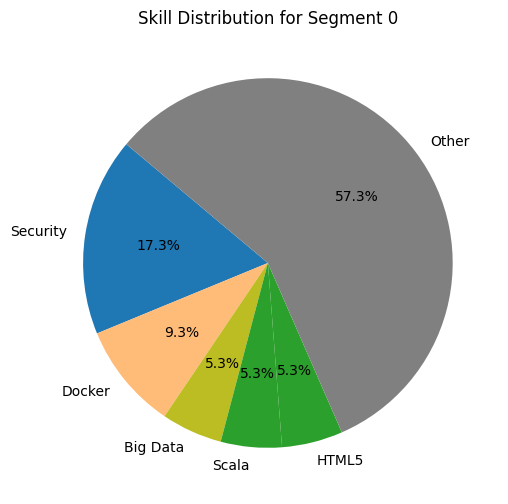

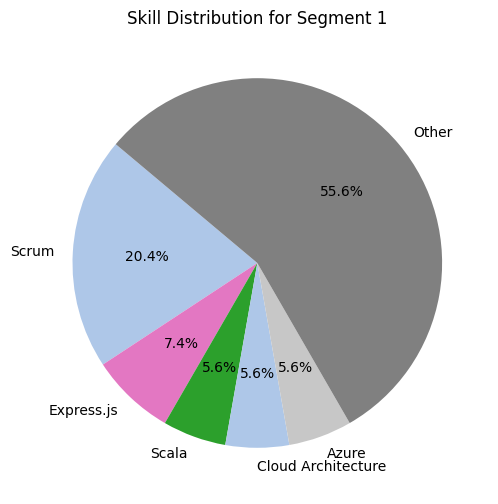

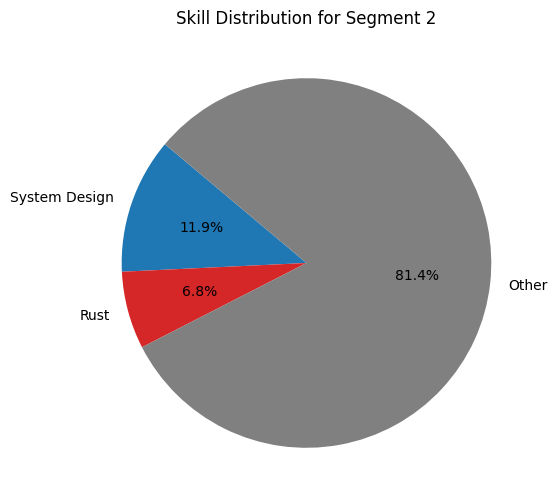

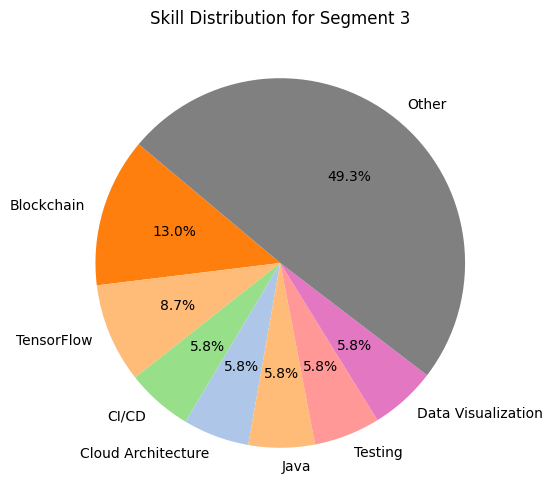

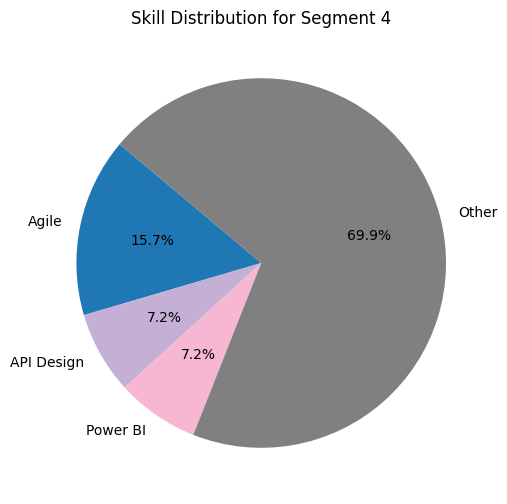

In [44]:
import matplotlib.pyplot as plt

# Assign unique colors based on cnt ordering from the original DataFrame
sorted_skills = df.groupby(["skill"])["cnt"].sum().sort_values(ascending=False).index
colors = plt.get_cmap("tab20", len(sorted_skills))  # Get a colormap
skill_color_map = {skill: colors(i) for i, skill in enumerate(sorted_skills)}

# Function to group small categories into "Other"
def group_small_categories(subset, threshold=5):
    total = subset["cnt"].sum()
    subset = subset.copy()  # Avoid modifying original dataframe
    subset["percentage"] = (subset["cnt"] / total) * 100

    # Separate main categories and small ones
    main_categories = subset[subset["percentage"] >= threshold]
    other_categories = subset[subset["percentage"] < threshold]

    if not other_categories.empty:
        other_cnt = other_categories["cnt"].sum()
        other_row = pd.DataFrame([{"skill": "Other", "cnt": other_cnt, "percentage": (other_cnt / total) * 100}])
        main_categories = pd.concat([main_categories, other_row], ignore_index=True)

    return main_categories

# Create pie charts with assigned colors
for segment in df["segmentId"].unique():
    subset = df[df["segmentId"] == segment].copy()
    grouped_subset = group_small_categories(subset)

    plt.figure(figsize=(6, 6))
    plt.pie(
        grouped_subset["cnt"],
        labels=grouped_subset["skill"],
        autopct="%1.1f%%",
        startangle=140,
        colors=[skill_color_map.get(skill, "gray") for skill in grouped_subset["skill"]],
    )
    plt.title(f"Skill Distribution for Segment {segment}")
    plt.show()